# MIRI PSF Photometry #1 - F770W PSF Photometry (Made Simple)

**Author**: Ori Fox
<br>
**Last Updated**: March, 2022

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Plotting functions imports](#matpl_imports)<br>
    2.3 [PSF FWHM dictionary](#psf_fwhm)<br>
3. [Import image to analyze](#data)<br>
    3.1 [Display image](#display_data)<br>
    3.2 [Convert image units and apply pixel area map](#convert_data)<br>
4. [Create a synthetic PSF model (with WebbPSF)](#webbpsf_intro)<br>
    4.1 [Create the single PSF](#single_webbpsf)<br>
    4.2 [Display the single PSF](#display_single_webbpsf)<br>
    4.3 [Create the grid of PSFs](#grid_webbpsf)<br>
    4.4 [Display the grid of PSFs](#display_grid_webbpsf)<br>
5. [Create the PSF model building an effective PSF](#epsf_intro)<br>
    5.1 [Calculate the background](#bkg)<br>
    5.2 [Find sources in the image](#find)<br>
    5.3 [Select sources](#select)<br>
    5.4 [Create catalog of selected sources](#create_cat)<br>
    5.5 [Build the effective PSF](#build_epsf)<br>
    5.6 [Display the effective PSF](#display_epsf)<br>
6. [Perform PSF Photometry](#psf_phot)<br>
    6.1 [PSF photometry output catalog](#psf_cat)<br>
    6.2 [Display residual images](#residual)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Data**: MIRI simulated images obtained using [MIRISIM](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) of Isochrone of 10-Gyr old population, [Fe/H]=-1 Population placed at 2.5 kpc from the Sun. Salpeter-like IMF, tweaked to have more massive stars (since positions are random, it ensures at least a few bright stars in each image). Kept only sources brighter than J=17 (random cut to speed up MIRISim) and fainter than Ks=10 (to avoid too-bright stars that would have PSF spikes clearly cut by MIRISim in the image)

Here is the [ReadMe](https://stsci.app.box.com/s/2b6evrie2swaybarxhdmpqizktl3g0wm/file/869444882607). All data simulations can be found on [STScI's simulation page](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/simulated-data).

PSF Photometry can be obtained using:

* single PSF model obtained from WebbPSF
* grid of PSF models from WebbPSF
* single effective PSF (ePSF)
* grid of effective PSF (bonus part II)

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PSF photometry on the image
* how to cross-match the catalogs of the different images (bonus part I)

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all the necessary python packages and we define some plotting parameters.

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
import os

if not os.environ.get('WEBBPSF_PATH'):
    os.environ['WEBBPSF_PATH'] = '/data/webbpsf-data'

import sys
import time

import numpy as np

import pandas as pd

import glob as glob

import urllib.request

import tarfile

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.detection import DAOStarFinder
from photutils import EPSFBuilder, GriddedPSFModel
from photutils.psf import DAOGroup, extract_stars, IterativelySubtractedPSFPhotometry

import jwst
from jwst.datamodels import ImageModel

import webbpsf
from webbpsf.utils import to_griddedpsfmodel

import pysynphot  # PYSIN_CDBS must be defined in the user's environment (see note below)

from collections import OrderedDict
from astropy.wcs import WCS

from jdaviz import Imviz

In [2]:
#
# General tools
#
import glob
import os
import shutil
import sys
import random
import urllib
import zipfile
#
# Astropy tools
#
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits, ascii
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table, Column, vstack
import astropy.units as u
from astropy.visualization import LogStretch, LinearStretch, PercentileInterval, ManualInterval
from astropy.nddata import Cutout2D
#
# JWST models
#
from jwst import datamodels, associations
from jwst.datamodels import ImageModel, dqflags
#
# Matplotlib tools
#
from matplotlib import style, pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#
# Numpy library
#
import numpy as np
#
# Photutils library and tools
#
import photutils
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground
#
# Scipy tools
#
from scipy import stats
from scipy.interpolate import CubicSpline
#
# Use 90% of the window width
#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

  from IPython.core.display import display, HTML

2022-04-14 05:13:06,855 - stpipe - WARNING - /var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_45978/2969300567.py:51: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML

  from IPython.core.display import display, HTML



<div class="alert alert-block alert-info">

**Note on pysynphot**: Data files for pysynphot are distributed separately by Calibration Reference Data System. They are expected to follow a certain directory structure under the root directory, identified by the PYSYN_CDBS environment variable that must be set prior to using this package. In the example below, the root directory is arbitrarily named /my/local/dir/trds/. \
export PYSYN_CDBS=/my/local/dir/trds/ \
See documentation [here](https://pysynphot.readthedocs.io/en/latest/#installation-and-setup) for the configuration and download of the data files.
    
<div >

### 2.2<font color='white'>-</font>Plot Settings<a class="anchor" id="matpl_imports"></a> ###

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [4]:
%matplotlib inline
# Figure size
plt.rcParams['figure.figsize'] = [15, 15]
# Figure text and font
plt.rc('text', usetex=True)
plt.rc('font', size=15)

### 2.3<font color='white'>-</font>PSF FWHM dictionary<a class="anchor" id="psf_fwhm"></a> ###

The dictionary contains the NIRCam point spread function (PSF) FWHM, from the [NIRCam Point Spread Function](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions) JDox page. The FWHM are calculated from the analysis of the expected NIRCam PSFs simulated with [WebbPSF](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool). 

**Note**: this dictionary will be updated once the values for the FWHM will be available for each detectors after commissioning.

In [5]:
filters = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F2550W']

psf_fwhm = [1.636, 2.187, 2.888, 3.318, 3.713, 4.354, 5.224, 5.989, 7.312] #pixls

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

In [6]:
### 2.4<font color='white'>-</font>Import images to analyze<a class="anchor" id="data"></a> ###

We load all the images and we create a dictionary that contains all of them, divided by detectors and filters. This is useful to check which detectors and filters are available and to decide if we want to perform the photometry on all of them or only on a subset.

We retrieve the MIRI detector and filter from the image header.

In [7]:
folder_path = './data/'

if (folder_path == './'):
    print('')
    print(' Please set another folder that is not the main folder.')
    print('')
    pass
elif os.path.isdir(folder_path):
    print('')
    print(' Images and catalogs should be already in \'' + folder_path + 
          '\'. If not, delete the folder and run this cell again.')
    print('')
    pass
elif (os.path.isfile('./stage2-selected.zip') and 
      os.path.isfile('./stage3-selected.zip')):
    # Extract both zip files if they are present
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)
else:
    # Download the data and extract both zip files
    boxlink = 'https://stsci.box.com/shared/static/8pjjn8nnaf1d1mev98ca9kc6mss7prmt.zip'
    boxfile = 'stage2-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    boxlink = 'https://stsci.box.com/shared/static/qstpome9vb95ay6aqlgvk0wvlku9ihay.zip'
    boxfile = 'stage3-selected.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    # Extract both zip files
    boxfile = './stage2-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)        
    boxfile = './stage3-selected.zip'
    with zipfile.ZipFile(boxfile) as zf:
        zf.extractall(folder_path)


 Images and catalogs should be already in './data/'. If not, delete the folder and run this cell again.



In [8]:
filter_names = ['F560W', 'F770W']

img_names = {}
cat_names = {}
for f in filter_names:
    print('')
    print(r'{0}-filter images:'.format(f))
    names = glob.glob(folder_path + 'det_*' + f + '*_cal.fits')
    for n in range(len(names)):
        print(r'     {0}) {1}'.format(n+1, names[n]))
    img_names[f] = names
    names = glob.glob(folder_path + 'complex_*' + f + '*cat*.ecsv')
    cat_names[f] = names
    print('')
    print(r'1 catalog found: {0}'.format(names[0]))


F560W-filter images:
     1) ./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits
     2) ./data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits
     3) ./data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits
     4) ./data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F560W_combined_cat.ecsv

F770W-filter images:
     1) ./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits
     2) ./data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits
     3) ./data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits
     4) ./data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F770W_combined_cat.ecsv


3.<font color='white'>-</font>Load Data <a class="anchor" id="load"></a>
------------------

In [9]:
file = './data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits'
#file = './data/jw01171-o003_t001_miri_f770w_i2d.fits'
im = fits.open(file)
hdr770 = im["SCI",1].header
w770 = WCS(im["SCI",1].header)

### 3.1<font color='white'>-</font>Display the image<a class="anchor" id="display_data"></a> ###

To check that our image does not present artifacts and can be used in the analysis, we display it. 

In [10]:
data_sb = im[1].data
_, med, sig = sigma_clipped_stats(data_sb, sigma=5.0, maxiters=5)

imviz = Imviz()
imviz.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [11]:
imviz.load_data(data_sb)

In [12]:
viewer = imviz.default_viewer
viewer.cuts = '95%'

### 3.2 Data Quality (DQ) Flags

Not all pixels should be used. We can use the Data Quality (DQ) flags to assess whether a pixel can be considered in calculations or not. [Here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags) you can find a description of the DQ flags.

There is no one-size-fits-all solution for selecting pixels using the DQ flags. For this specific exercise, let's keep all pixels with DQ flag equal to:

- 0 = Good pixel
- 2 = Pixel saturated during integration
- 4 = Jump detected during integration
- 6 = Combination of DQ flags 2 and 4

As we can see, the DQ flags can correspond to multiple features. We can use _dqflags.dqflags_to_mnemonics_ to convert the DQ integer values into more user-friendly names:

In [13]:
print(r' DQ flag equal to 2: {0}'.format(dqflags.dqflags_to_mnemonics(2, dqflags.group)))
print(r' DQ flag equal to 4: {0}'.format(dqflags.dqflags_to_mnemonics(4, dqflags.group)))
print(r' DQ flag equal to 6: {0}'.format(dqflags.dqflags_to_mnemonics(6, dqflags.group)))

 DQ flag equal to 2: {'SATURATED'}
 DQ flag equal to 4: {'JUMP_DET'}
 DQ flag equal to 6: {'SATURATED', 'JUMP_DET'}


Let's flag all pixels with a DQ flag different from these four values:

Third extension is the DQ flags
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#rate

In [14]:
ok = np.zeros(im[1].data.shape, dtype='int')
ok = ok + np.where(im[3].data != 1, 0, 1)
print(r'{0} out of {1} pixels are not usable (~{2:3.1f}%)'.format((ok == 1).sum(), im[1].data.shape[0]*im[1].data.shape[1], 
                                                                  (ok == 1).sum()/(im[1].data.shape[0]*im[1].data.shape[1])*100.0))

0 out of 1056768 pixels are not usable (~0.0%)


In [15]:
data_bad = data_sb
#data_bad[ok] = np.nan

After masking, the same MIRI image looks different:

In [16]:
#imshow_me_wcolorbar(im[1].data, med-1*sig, med+1*sig, 'Image after masking', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
imviz = Imviz()
imviz.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [17]:
imviz.load_data(data_bad)
viewer = imviz.default_viewer
viewer.cuts = '95%'

As we can notice, the regions associated to the 4-quadrant phase mask (4QPM) coronagraphs disappeared from the image. The optical system of the 4QPM coronographs is different from that of the imager. Because of the way these optical elements affect the light transmission, the calibration of the 4QPM-coronograph regions is complicated and specific for these coronographs. Therefore, even though photons are detected in the regions of the coronagraphs during standard imaging observations, these regions should not be used while analyzing the Stage-2 image. If you run the _calwebb_image3_ pipeline (or the resample step in _calwebb_image2_), you will notice that the 4QPM regions are missing in the resampled image (_i2d.fits_) as well.

Another feature we can notice is that two columns (# 385 and 386) were flagged. Although a qualitative assessment of the image (for example with ds9) does not show anything particularly different from the other columns, these two columns showed to be coupled and should not be used for science.

### 3.3<font color='white'>-</font>Convert image units and apply pixel area map<a class="anchor" id="convert_data"></a> ###

The unit of the Level-2 and Level-3 Images from the pipeline is MJy/sr (hence a surface brightness). The actual unit of the image can be checked from the header keyword **BUNIT**. The scalar conversion constant is copied to the header keyword **PHOTMJSR**, which gives the conversion from DN/s to megaJy/steradian. For our analysis we revert back to DN/s.

For images that have not been transformed into a distortion-free frame (i.e. not drizzled), a correction must be applied to account for the different on-sky pixel size across the field of view. A pixel area map (PAM), which is an image where each pixel value describes that pixel's area on the sky relative to the native plate scale, is used for this correction. In the stage 2 of the JWST pipeline, the PAM is copied into an image extension called **AREA** in the science data product. 

In [18]:
imh = im[1].header
data = data_bad / imh['PHOTMJSR']
print('Conversion factor from {units} to DN/s for filter F770W:', imh['PHOTMJSR'])
area = im[4].data
data = data * area

Conversion factor from {units} to DN/s for filter F770W: 0.5927879810333252


4.<font color='white'>-</font>Create synthetic PSF (with WebbPSF) <a class="anchor" id="webbpsf_intro"></a>
------------------

WebbPSF is a Python package that computes simulated PSFs for NASA’s JWST and Nancy Grace Roman Space Telescope (formerly WFIRST). WebbPSF transforms models of telescope and instrument optical state into PSFs, taking into account detector pixel scales, rotations, filter profiles, and point source spectra. It is not a full optical model of JWST, but rather a tool for transforming optical path difference (OPD) maps, created with some other tool, into the resulting PSFs as observed with JWST’s or Roman’s instruments. For a full documentation on WebbPSF, see [here](https://webbpsf.readthedocs.io/en/latest/) and for is capability and limitation, see [here](https://webbpsf.readthedocs.io/en/latest/intro.html).

The function below allows to create a single PSF or a grid of PSFs (the PSF can also be saved as a fits file). First, we need to specify the instrument (MIRI), detector, and filter. Then, to create a single (or grid) PSF we use the webbPSF method *psf_grid*, which will output a (list of or single) photutils GriddedPSFModel object(s). A tutorial notebook on the *psf_grid* method can be found [here](https://github.com/spacetelescope/webbpsf/blob/stable/notebooks/Gridded_PSF_Library.ipynb).

**Important Parameters**:

* `num`: the total number of fiducial PSFs to be created and saved in the files. This
    number must be a square number (4, 9, 16, etc.)

* `oversample`: the oversample factor we want to adopt in the PSF creation.

* `fov`: the size in pixel of the PSF model. The size depends on the shape of the PSF and how much flux is contained in the wings of the PSFs (i.e., a small field of view will exclude more flux from the PSF wings). However, increasing the field of view, increase also the computational time, so we need to find a reasonable compromise.

* `source`: the source spectrum we want to adopt. Source spectra are defined using the function  `webbpsf.specFromSpectralType` where we need to define the spectral type and the model library (e.g., webbpsf.specFromSepectralType('G5V', catalog='phoenix')). See also note below on the default spectrum depending on if pysynphot is installed or not. 

* `all_detectors`: run all detectors for the instrument. Since we analyze only 1 detector, we set `all_detectors = False` (we do not need to create a PSF model for all MIRI detectors).

* `use_detsampled_psf`: If the grid of PSFs returned will be detector sampled (made by binning down the oversampled PSF) or oversampled by the factor defined by the oversample. For our analysis, we want to create an oversampled PSF model, so we set `use_detsampled_psf = False`.

<div class="alert alert-block alert-info">
    
**Note on centering**: by default, the PSF will be centered at the exact center of the output array. This means that if the PSF is computed on an array with an odd number of pixels, the PSF will be centered exactly on the central pixel. If the PSF is computed on an array with even size, it will be centered on the “crosshairs” at the intersection of the central four pixels.

**Note on normalization**: by default, PSFs are normalized to total intensity = 1.0 at the entrance pupil (i.e. at the JWST OTE primary). A PSF calculated for an infinite aperture would thus have integrated intensity =1.0. A PSF calculated on any smaller finite subarray will have some finite encircled energy less than one.

**Note on source spectrum**: The default source spectrum is, if *pysynphot* is installed, a G2V star spectrum from Castelli & Kurucz (2004). Without *pysynphot*, the default is a simple flat spectrum such that the same number of photons are detected at each wavelength.

</div>

### 4.1<font color='white'>-</font>Create the single PSF<a class="anchor" id="single_webbpsf"></a> ###

In [19]:
psfs_dir = 'PSF_MODELS/'
det = 'MIRIM'
filt = 'F770W'
fov=11
outname = 'PSF_F770W_samp4_fov11_npsfs1'

miri = webbpsf.MIRI()
miri.detector = det
miri.filter = filt
psf = miri.psf_grid(num_psfs=1, oversample=4, source=None, all_detectors=False, fov_pixels=fov, 
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=False)


Running instrument: MIRI, filter: F770W
  Running detector: MIRIM
    Position 1/1: (511, 511) pixels


  warnings.warn('Card is too long, comment will be truncated.',

2022-04-14 05:14:28,756 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/io/fits/card.py:1009: VerifyWarning: Card is too long, comment will be truncated.
  warnings.warn('Card is too long, comment will be truncated.',

  warnings.warn('Card is too long, comment will be truncated.',



  Saving file: PSF_MODELS/PSF_F770W_samp4_fov11_npsfs1_mirim.fits


Although the above commands will create a PSF model using WebbPSF, the MIRI team has premade PSFs available for direct download so you don't need to install and run WebbPSF on your own.

In [20]:
if os.path.exists("PSF_MODELS/"):
    print("PSF_MODELS Exist, But worth DOUBLE-CHECKING all latest PSF files are there")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_photometry/PSF_MODELS.tar.gz'
    urllib.request.urlretrieve(url, './PSF_MODELS.tar.gz')
    
    # Unzip Tar Files
    import tarfile

    tar = tarfile.open('./PSF_MODELS.tar.gz', "r:gz")
    tar.extractall()
    tar.close()

PSF_MODELS Exist, But worth DOUBLE-CHECKING all latest PSF files are there


In [21]:
# Read in the single psf

psf_webbpsf_single = to_griddedpsfmodel('./PSF_MODELS/PSF_F770W_samp4_fov11_npsfs1_mirim.fits')  # file created 2 cells above
psf_webbpsf_single

<GriddedPSFModel(flux=1., x_0=0., y_0=0.)>

### 4.2<font color='white'>-</font>Display the single PSF<a class="anchor" id="display_single_webbpsf"></a> ###

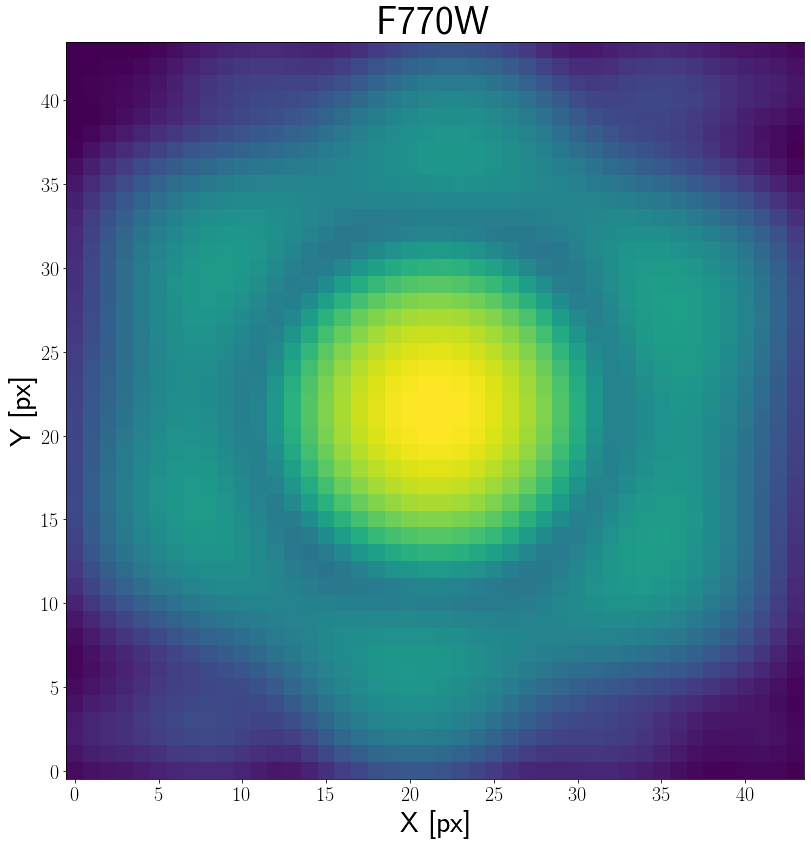

In [22]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 1, 1)

norm_psf = simple_norm(psf_webbpsf_single.data[0], 'log', percent=99.)
ax.set_title(filt, fontsize=40)
ax.imshow(psf_webbpsf_single.data[0], norm=norm_psf)
ax.set_xlabel('X [px]', fontsize=30)
ax.set_ylabel('Y [px]', fontsize=30)
plt.tight_layout()

5.<font color='white'>-</font>Perform PSF Photometry<a class="anchor" id="psf_phot"></a>
------------------

For general information on PSF Photometry with PhotUtils see [here](https://photutils.readthedocs.io/en/stable/psf.html). 

Photutils provides three classes to perform PSF Photometry: [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), [IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry), and [DAOPhotPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOPhotPSFPhotometry.html#photutils.psf.DAOPhotPSFPhotometry). Together these provide the core workflow to make photometric measurements given an appropriate PSF (or other) model.

[BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry) implements the minimum tools for model-fitting photometry. At its core, this involves finding sources in an image, grouping overlapping sources into a single model, fitting the model to the sources, and subtracting the models from the image. In DAOPHOT parlance, this is essentially running the “FIND, GROUP, NSTAR, SUBTRACT” once.

[IterativelySubtractedPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IterativelySubtractedPSFPhotometry.html#photutils.psf.IterativelySubtractedPSFPhotometry) (adopted here) is similar to [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), but it adds a parameter called `n_iters` which is the number of iterations for which the loop “FIND, GROUP, NSTAR, SUBTRACT, FIND…” will be performed. This class enables photometry in a scenario where there exists significant overlap between stars that are of quite different brightness. For instance, the detection algorithm may not be able to detect a faint and bright star very close together in the first iteration, but they will be detected in the next iteration after the brighter stars have been fit and subtracted. Like [BasicPSFPhotometry](https://photutils.readthedocs.io/en/stable/api/photutils.psf.BasicPSFPhotometry.html#photutils.psf.BasicPSFPhotometry), it does not include implementations of the stages of this process, but it provides the structure in which those stages run.

**Important parameters**:

* `finder`: classes to find stars in the image. We use [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html).

* `group_maker`:  clustering algorithm in order to label the sources according to groups. We use [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup). The method group_stars divides an entire starlist into sets of distinct, self-contained groups of mutually overlapping stars. It accepts as input a list of stars and determines which stars are close enough to be capable of adversely influencing each others’ profile fits. [DAOGroup](https://photutils.readthedocs.io/en/stable/api/photutils.psf.DAOGroup.html#photutils.psf.DAOGroup) aceepts one parameter, `crit_separation`, which is the distance, in units of pixels, such that any two stars separated by less than this distance will be placed in the same group.

* `fitter`: algorithm to fit the sources simultaneously for each group. We use an astropy fitter, [LevMarLSQFitter](https://docs.astropy.org/en/stable/api/astropy.modeling.fitting.LevMarLSQFitter.html#astropy.modeling.fitting.LevMarLSQFitter). 

* `niters`: number of iterations for which the "psf photometry" loop described above is performed.

* `fitshape`: Rectangular shape around the center of a star which will be used to collect the data to do the fitting. 

* `aperture_radius`: The radius (in units of pixels) used to compute initial estimates for the fluxes of sources.

In [23]:
output_phot_dir = 'PHOT_OUTPUT/'

if not os.path.exists(output_phot_dir):
    os.makedirs(output_phot_dir)

res_dir = 'RESIDUAL_IMAGES/'

if not os.path.exists(res_dir):
    os.makedirs(res_dir)

if glob.glob(os.path.join(res_dir, 'residual*F770W.fits')):
    print('Deleting Residual images from directory')
    files = glob.glob(os.path.join(res_dir, 'residual*F770W.fits'))
    for file in files:
        os.remove(file)

Deleting Residual images from directory


### 5.1<font color='white'>-</font>Calculate Background<a class="anchor" id="background"></a> ###

##### Standard Background Calculation

In [24]:
bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()
std = bkgrms(data)
bkg = mmm_bkg(data)

data_bkgsub = data.copy()
data_bkgsub -= bkg


##### 2D Variable Background Calculation

### 5.2<font color='white'>-</font>Perform Photometry<a class="anchor" id="background"></a> ###

In [25]:
fitter = LevMarLSQFitter()
mmm_bkg = MMMBackground()
th = 5.
ap_radius=5.5
        
sigma_psf = dict_utils[filt]['psf fwhm']
print('FWHM for filter {f}:'.format(f=filt), sigma_psf*2)
    
daofind = DAOStarFinder(threshold=th * std, fwhm=sigma_psf)
daogroup = DAOGroup(5.0 * sigma_psf)
    
psf_model = psf_webbpsf_single.copy()
    
print('Performing the PSF photometry')
tic = time.perf_counter()
    
phot = IterativelySubtractedPSFPhotometry(finder=daofind, group_maker=daogroup,
                                            bkg_estimator=mmm_bkg, psf_model=psf_model,
                                            fitter=fitter,
                                            niters=3, fitshape=(11, 11), aperture_radius=ap_radius, 
                                            extra_output_cols=('sharpness', 'roundness2'))
psf_phot_results = phot(data)
toc = time.perf_counter()
    
print('Time needed to perform photometry:', '%.2f' % ((toc - tic) / 3600), 'hours')
print('Number of sources detected:', len(psf_phot_results))
        
residual_image = phot.get_residual_image()
    
# save the residual images as fits file:
hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])
    
residual_outname = 'residual_MIRIM_F770W.fits'
hdul.writeto(os.path.join(res_dir, residual_outname),overwrite=True)

# save the output photometry Tables
outname = 'phot_MIRIM_F770W.pkl'
tab = psf_phot_results.to_pandas()
tab.to_pickle(os.path.join(output_phot_dir, outname))

FWHM for filter F770W: 4.374
Performing the PSF photometry


  warnings.warn("The fit may be unsuccessful; check "

2022-04-14 05:14:45,843 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  warnings.warn("The fit may be unsuccessful; check "

  warnings.warn("The fit may be unsuccessful; check "

2022-04-14 05:15:36,945 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/modeling/fitting.py:1169: AstropyUserWarning: The fit may be unsuccessful; check fit_info['message'] for more information.
  warnings.warn("The fit may be unsuccessful; check "

  warnings.warn("The fit may be unsuccessful; check "

  warnings.warn("The fit may be unsuccessful; check "

2022-04-14 05:16:58,343 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/astropy/modeling/fittin

KeyboardInterrupt: 

### 5.3<font color='white'>-</font>PSF photometry output catalog<a class="anchor" id="psf_cat"></a> ###

In [ ]:
psf_phot_results

### 5.4<font color='white'>-</font>Display residual image<a class="anchor" id="residual"></a> ###

In [ ]:
#imshow_me_wcolorbar(im[1].data, med-1*sig, med+1*sig, 'Image after masking', 'x [MIRIM pixel]', 'y [MIRIM pixel]', 'MJy sr$^{-1}$', 'binary')
imviz = Imviz()
imviz.app

In [ ]:
imviz.load_data(residual_image,data_label='Residual')
imviz.load_data(data,data_label='Original')
viewer = imviz.default_viewer
viewer.cuts = '95%'

In [ ]:
viewer_2_name='Window 2'
viewer_2 = imviz.create_image_viewer(viewer_name=viewer_2_name)

In [ ]:
imviz.app.add_data_to_viewer(viewer_2_name, 'Residual')

In [ ]:
viewer_2.cuts = '95%'

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>